In [1]:
import cv2
import os
import sys
import glob
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageSequence, ImageEnhance, ImageFilter 
from skimage import measure, color, io
from skimage.segmentation import clear_border
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_otsu
from skimage.draw import polygon_perimeter

In [2]:
os.getcwd() # Check whether you are working in the correct directory: directory where your machine learning segmented cell image is stored.

'/Users/laurenhyoseoyoon/Dropbox/2022_SUMMER/Kozorovitskiy-Lab/3d-pipeline/series5'

In [3]:
def zstack_to_slice(img):
    stack = Image.open(img)
    for i, page in enumerate(ImageSequence.Iterator(stack)):
        page.save("zslice_%d.tif" % i)

zstack_to_slice("Series5_C1_cp_masks_cellprobthresh0.tif")

In [4]:
## Sanity Check

for name in glob.glob('zslice_*.tif'):
    print(name)

zslice_4.tif
zslice_2.tif
zslice_3.tif
zslice_1.tif
zslice_0.tif


In [5]:
def mean_projection(prefix):
    '''
    prefix = prefix where file names of each z-slice have in common (use double quotation mark when typing prefix)
    '''
    ## import all image files with the .tif extension
    images = glob.glob('%s_*.tif' % prefix)

    image_data = []
    for img in images:
        image = cv2.imread(img, -1)
        image_scaled = cv2.normalize(image, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
        image_data.append(image_scaled)

    ## Mean projection of each z-slices
    avg_image = image_data[0]
    for i in range(len(image_data)):
        if i == 0:
            pass
        else:
            alpha = 1.0/(i + 1)
            beta = 1.0 - alpha
            avg_image = cv2.addWeighted(image_data[i], alpha, avg_image, beta, 0.0)

    cv2.imwrite('avg_cell.tif', avg_image)
    avg_image = cv2.imread('avg_cell.tif')
    plt.imshow(avg_image)
    plt.show()

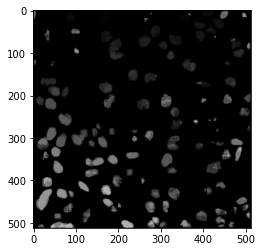

In [6]:
mean_projection("zslice")

In [7]:
def image_processing(img):
    ''' 
    img = file name of the mean projection of zslices
    '''
    ## Image processing -> Brightness, Sharpness
    file = img
    image = Image.open(file)
    brightener = ImageEnhance.Brightness(image.convert('RGB'))

    # for i in range(8):
    #     factor = i / 4.0
    #     brightener.enhance(factor).show(f"Sharpness {factor:f}")

    pil_image1 = brightener.enhance(2)
    # pil_image1.show()

    sharpener = ImageEnhance.Sharpness(pil_image1.convert('RGB'))

    # for i in range(8):
    #     factor = i / 4.0
    #     sharpener.enhance(factor).show(f"Sharpness {factor:f}")

    pil_image2 = sharpener.enhance(2)
    pil_image2.show()

    nimg = np.array(pil_image2)
    ocvim = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    fnam = "avg_cell_cv2.tif"
    cv2.imwrite(fnam, ocvim)


In [8]:
image_processing("avg_cell.tif")

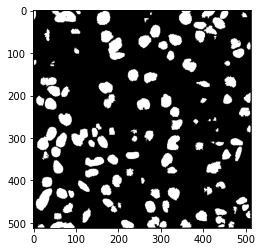

In [9]:
avg_cell = cv2.imread('avg_cell_cv2.tif', 0)
plt.imshow(avg_cell, cmap='gray')

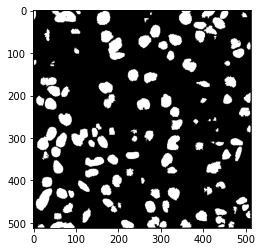

In [10]:
avg_cell = cv2.imread('avg_cell_cv2.tif')
cells = avg_cell[:,:,0]
plt.imshow(cells, cmap='gray')

## APPROACH 1

In [11]:
def detect_and_label_cell(img):

    avg_cell = cv2.imread(img)
    cells = avg_cell[:,:,0]

    ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint16)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    opening = clear_border(opening)

    ## SURE BACKGROUND
    sure_back = cv2.dilate(opening, kernel, iterations=10)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

    ## SURE FOREGROUND
    ret2, sure_fore = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)
    sure_fore = np.uint8(sure_fore)

    ## UNKNOWN REGION 
    unknown = cv2.subtract(sure_back, sure_fore)

    ret3, markers = cv2.connectedComponents(sure_fore)
    markers += 10 
        # NOTE adding 10 ensures that the sure background value is 10 not 0. We need this step b/c watershed algorithm will consider the background pixel value of 0 as unknown, which we do NOT want. 
    markers[unknown==255] = 0
        # Background = grayish (value of 10), Unknown = value 0

    ## WATERSHED FILLING STEP
    markers = cv2.watershed(avg_cell, markers) # NOTE in order to perform a watershed, the image should be read in a color (3 channels) format not a grayscale. 
    avg_cell[markers==-1] = [0, 255, 255] # NOTE that watershed assigns the value of -1 to the boundaries. We are assigning the Yellow color to the borders. 
    avg_cell_marked = color.label2rgb(markers, bg_label=0)
    
    from PIL import Image
    avg_cell_marked2 = Image.fromarray(markers.astype('uint8'), mode='L')
    avg_cell_marked2.save("avg_cell_marked2.tif", "TIFF")

    nimg = np.array(avg_cell_marked, dtype=np.float32)
    ocvim = cv2.cvtColor(nimg, cv2.COLOR_RGB2HSV_FULL)
    fnam = "avg_cell_marked.tif"
    cv2.imwrite(fnam, ocvim)

    ## EXTRACT INFORMATION OF DETECTED CELLS
    props = measure.regionprops_table(markers, cells, properties=['label','bbox','centroid','area','equivalent_diameter', 'mean_intensity', 'solidity', 'orientation', 'perimeter'])
    pixels_to_um = 0.264 
    props_df = pd.DataFrame(props)
    # print(props_df.head())
    props_df.to_csv('props_df.csv')

In [12]:
detect_and_label_cell('avg_cell_cv2.tif')
props_df = pd.read_csv('props_df.csv', index_col=0)

In [13]:
print(props_df.columns)
print(props_df.shape) 
    # NOTE Bounding box (min_row, min_col, max_row, max_col). Pixels belonging to the bounding box are in the half-open interval [min_row; max_row) and [min_col; max_col).

Index(['label', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'centroid-0',
       'centroid-1', 'area', 'equivalent_diameter', 'mean_intensity',
       'solidity', 'orientation', 'perimeter'],
      dtype='object')
(79, 13)
